# Train an neural network for regression

- Watch this video https://lightning.ai/docs/pytorch/stable/starter/introduction.html

In [1]:
# pip install lightning pandas matplotlib

In [2]:
# Replace this test data with your data
import numpy as np
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train[:5000]
y_train = y_train[:5000]

x_test = x_test[:1000]
y_test = y_test[:1000]

print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)
print(x_test.shape)

2024-01-30 15:44:58.285107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 15:44:58.285166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 15:44:58.285995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 15:44:58.291092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 15:44:58.885322: W tensorflow/compiler/tf2

(5000, 32, 32, 3)
uint8
(5000, 1)
int64
(1000, 32, 32, 3)


In [3]:
import torch.utils.data as data_utils
import numpy as np
from sklearn.model_selection import train_test_split
import torch

# Train
train_fps = torch.Tensor(x_train.astype(np.float32))
train_values = torch.Tensor(y_train.astype(np.float32))
train_data = data_utils.TensorDataset(train_fps, train_values)
train_loader = data_utils.DataLoader(train_data, batch_size=100, shuffle=False)

# Validation
val_fps = torch.Tensor(x_test.astype(np.float32))
val_values = torch.Tensor(y_test.astype(np.float32))
val_data = data_utils.TensorDataset(val_fps, val_values)
val_loader = data_utils.DataLoader(val_data, batch_size=100, shuffle=False)

# Test
# test loader, we use the same dataset as for val (for now); no values here
test_fps = torch.Tensor(x_test.astype(np.float32))
test_values = torch.Tensor(y_test.astype(np.float32))
test_loader = data_utils.DataLoader(test_fps, batch_size=100, shuffle=False)
# for i in train_loader:
#     print(i[0].shape)
#     print(i[0].dtype)
#     print(i[1].shape)
#     print(i[1].dtype)
#     break

In [10]:
import torch, torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import lightning as L

# --------------------------------
# Define a LightningModule by subclassing LightningModule
# A LightningModule is a subclass of nn.Module


class LitImageRegressor(L.LightningModule):
    def __init__(self):
        # -- Define your NN
        super().__init__()

        # in_channels, out_channels, kernel_size, stride
        # (50000, 32, 32, 3)
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(2048, 300)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(300, 100)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(100, 1)

    def forward(self, x):
        # -- Define how to go forward through your NN
        # call the conv bloc
        x = self.act1(self.conv1(x))
        x = self.drop1(x)

        x = self.act2(self.conv2(x))

        x = self.pool2(x)

        x = self.flat(x)

        x = self.act3(self.fc3(x))
        x = self.drop3(x)

        x = self.act4(self.fc4(x))
        x = self.drop4(x)

        x = self.fc5(x)
        return x

    def training_step(self, batch, batch_idx):
        # -- Define how to do a training step
        # Split to input and output as you defined it in your dataloader
        x, y = batch
        # fog forward and get prediction
        x = self.forward(x)
        # compute loss
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(y, x)
        # log the loss (for plotting later)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # -- Define how to do a validation step (similar to raining)
        x, y = batch
        x = self.forward(x)
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(x, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Define the optimize that you want to use
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Train

In [11]:
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from pathlib import Path
import shutil


save_dir = Path("my_model")
if save_dir.exists():
    shutil.rmtree(save_dir)

callbacks = [
    ModelCheckpoint(dirpath=save_dir, save_top_k=1, monitor="val_loss", verbose=True),
    ModelSummary(max_depth=-1),
    # EarlyStopping(monitor="val_loss", mode="min", verbose=True),
]


regressor = LitImageRegressor()
trainer = L.Trainer(
    max_epochs=200,
    log_every_n_steps=1,
    val_check_interval=1,
    callbacks=callbacks,
    logger=CSVLogger("lightning_logs"),
)
trainer.fit(model=regressor, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name  | Type      | Params
-------------------------------------
0  | conv1 | Conv2d    | 18.5 K
1  | act1  | ReLU      | 0     
2  | drop1 | Dropout   | 0     
3  | conv2 | Conv2d    | 73.9 K
4  | act2  | ReLU      | 0     
5  | pool2 | MaxPool2d | 0     
6  | flat  | Flatten   | 0     
7  | fc3   | Linear    | 614 K 
8  | act3  | ReLU      | 0     
9  | drop3 | Dropout   | 0     
10 | fc4   | Linear    | 30.1 K
11 | act4  | ReLU      | 0     
12 | drop4 | Dropout   | 0     
13 | fc5   | Linear    | 101   
-------------------------------------
737 K     Trainable params
0         Non-trainable params
737 K     Total params
2.949     Total estimated model params size (MB)


/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 50/50 [00:02<00:00, 23.83it/s, v_num=3, train_loss=1.19e+3, val_loss=1.5e+3] 

Epoch 0, global step 50: 'val_loss' reached 1499.59497 (best 1499.59497), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=0-step=50.ckpt' as top 1


Epoch 1: 100%|██████████| 50/50 [00:02<00:00, 22.10it/s, v_num=3, train_loss=1.1e+3, val_loss=1.56e+3] 

Epoch 1, global step 100: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 50/50 [00:02<00:00, 20.11it/s, v_num=3, train_loss=1.18e+3, val_loss=1.52e+3]

Epoch 2, global step 150: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 50/50 [00:02<00:00, 20.09it/s, v_num=3, train_loss=1.28e+3, val_loss=1.49e+3]

Epoch 3, global step 200: 'val_loss' reached 1486.03552 (best 1486.03552), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=3-step=200.ckpt' as top 1


Epoch 4: 100%|██████████| 50/50 [00:02<00:00, 20.04it/s, v_num=3, train_loss=1.21e+3, val_loss=1.7e+3] 

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 50/50 [00:02<00:00, 20.10it/s, v_num=3, train_loss=1.09e+3, val_loss=1.44e+3]

Epoch 5, global step 300: 'val_loss' reached 1435.90063 (best 1435.90063), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=5-step=300.ckpt' as top 1


Epoch 6: 100%|██████████| 50/50 [00:02<00:00, 20.04it/s, v_num=3, train_loss=1.11e+3, val_loss=1.42e+3]

Epoch 6, global step 350: 'val_loss' reached 1419.37915 (best 1419.37915), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=6-step=350.ckpt' as top 1


Epoch 7: 100%|██████████| 50/50 [00:02<00:00, 20.05it/s, v_num=3, train_loss=1.08e+3, val_loss=1.47e+3]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 50/50 [00:02<00:00, 19.97it/s, v_num=3, train_loss=1.02e+3, val_loss=1.41e+3]

Epoch 8, global step 450: 'val_loss' reached 1413.09729 (best 1413.09729), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=8-step=450.ckpt' as top 1


Epoch 9: 100%|██████████| 50/50 [00:02<00:00, 19.91it/s, v_num=3, train_loss=1.12e+3, val_loss=1.5e+3] 

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 50/50 [00:02<00:00, 20.01it/s, v_num=3, train_loss=1e+3, val_loss=1.47e+3]   

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 50/50 [00:02<00:00, 20.06it/s, v_num=3, train_loss=1.1e+3, val_loss=1.51e+3] 

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s, v_num=3, train_loss=1.05e+3, val_loss=1.61e+3]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 50/50 [00:02<00:00, 20.09it/s, v_num=3, train_loss=1.12e+3, val_loss=1.41e+3]

Epoch 13, global step 700: 'val_loss' reached 1409.50745 (best 1409.50745), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=13-step=700.ckpt' as top 1


Epoch 14: 100%|██████████| 50/50 [00:02<00:00, 19.94it/s, v_num=3, train_loss=1.15e+3, val_loss=1.4e+3] 

Epoch 14, global step 750: 'val_loss' reached 1396.52625 (best 1396.52625), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=14-step=750.ckpt' as top 1


Epoch 15: 100%|██████████| 50/50 [00:02<00:00, 19.31it/s, v_num=3, train_loss=1.02e+3, val_loss=1.36e+3]

Epoch 15, global step 800: 'val_loss' reached 1360.80383 (best 1360.80383), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=15-step=800.ckpt' as top 1


Epoch 16: 100%|██████████| 50/50 [00:02<00:00, 19.42it/s, v_num=3, train_loss=1.05e+3, val_loss=1.39e+3]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 50/50 [00:02<00:00, 19.34it/s, v_num=3, train_loss=1.04e+3, val_loss=1.4e+3] 

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 50/50 [00:02<00:00, 18.95it/s, v_num=3, train_loss=1.02e+3, val_loss=1.62e+3]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s, v_num=3, train_loss=1.01e+3, val_loss=1.56e+3]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s, v_num=3, train_loss=981.0, val_loss=1.54e+3]  

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s, v_num=3, train_loss=892.0, val_loss=1.34e+3]  

Epoch 21, global step 1100: 'val_loss' reached 1343.79822 (best 1343.79822), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=21-step=1100.ckpt' as top 1


Epoch 22: 100%|██████████| 50/50 [00:02<00:00, 19.88it/s, v_num=3, train_loss=942.0, val_loss=1.54e+3]  

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 50/50 [00:01<00:00, 27.95it/s, v_num=3, train_loss=1e+3, val_loss=1.48e+3]   

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 50/50 [00:01<00:00, 28.87it/s, v_num=3, train_loss=1.17e+3, val_loss=1.28e+3]

Epoch 24, global step 1250: 'val_loss' reached 1284.93201 (best 1284.93201), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=24-step=1250.ckpt' as top 1


Epoch 25: 100%|██████████| 50/50 [00:01<00:00, 28.87it/s, v_num=3, train_loss=975.0, val_loss=1.3e+3]   

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 50/50 [00:01<00:00, 29.28it/s, v_num=3, train_loss=978.0, val_loss=1.51e+3]  

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 50/50 [00:01<00:00, 30.32it/s, v_num=3, train_loss=932.0, val_loss=1.57e+3]  

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 50/50 [00:01<00:00, 29.18it/s, v_num=3, train_loss=1.05e+3, val_loss=1.53e+3]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s, v_num=3, train_loss=1.05e+3, val_loss=1.35e+3]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 50/50 [00:01<00:00, 28.56it/s, v_num=3, train_loss=1e+3, val_loss=1.21e+3]   

Epoch 30, global step 1550: 'val_loss' reached 1207.15674 (best 1207.15674), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=30-step=1550.ckpt' as top 1


Epoch 31: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s, v_num=3, train_loss=826.0, val_loss=1.18e+3]  

Epoch 31, global step 1600: 'val_loss' reached 1179.09265 (best 1179.09265), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=31-step=1600.ckpt' as top 1


Epoch 32: 100%|██████████| 50/50 [00:01<00:00, 28.52it/s, v_num=3, train_loss=940.0, val_loss=1.16e+3]  

Epoch 32, global step 1650: 'val_loss' reached 1158.57227 (best 1158.57227), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=32-step=1650.ckpt' as top 1


Epoch 33: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s, v_num=3, train_loss=757.0, val_loss=1.21e+3]  

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 50/50 [00:01<00:00, 28.72it/s, v_num=3, train_loss=884.0, val_loss=942.0]    

Epoch 34, global step 1750: 'val_loss' reached 942.21973 (best 942.21973), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=34-step=1750.ckpt' as top 1


Epoch 35: 100%|██████████| 50/50 [00:01<00:00, 28.83it/s, v_num=3, train_loss=954.0, val_loss=907.0]  

Epoch 35, global step 1800: 'val_loss' reached 907.04352 (best 907.04352), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=35-step=1800.ckpt' as top 1


Epoch 36: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s, v_num=3, train_loss=973.0, val_loss=902.0]  

Epoch 36, global step 1850: 'val_loss' reached 902.24652 (best 902.24652), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=36-step=1850.ckpt' as top 1


Epoch 37: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s, v_num=3, train_loss=886.0, val_loss=912.0]  

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 50/50 [00:01<00:00, 27.75it/s, v_num=3, train_loss=835.0, val_loss=904.0]  

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 50/50 [00:02<00:00, 24.41it/s, v_num=3, train_loss=902.0, val_loss=968.0]  

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 50/50 [00:01<00:00, 28.80it/s, v_num=3, train_loss=909.0, val_loss=916.0]  

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 50/50 [00:01<00:00, 27.27it/s, v_num=3, train_loss=867.0, val_loss=923.0]  

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 50/50 [00:01<00:00, 28.93it/s, v_num=3, train_loss=917.0, val_loss=905.0]  

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 50/50 [00:01<00:00, 28.84it/s, v_num=3, train_loss=868.0, val_loss=899.0] 

Epoch 43, global step 2200: 'val_loss' reached 898.65350 (best 898.65350), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=43-step=2200.ckpt' as top 1


Epoch 44: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s, v_num=3, train_loss=948.0, val_loss=901.0]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s, v_num=3, train_loss=692.0, val_loss=961.0]  

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 50/50 [00:01<00:00, 28.73it/s, v_num=3, train_loss=931.0, val_loss=912.0]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 50/50 [00:01<00:00, 28.71it/s, v_num=3, train_loss=832.0, val_loss=934.0]  

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 50/50 [00:01<00:00, 28.83it/s, v_num=3, train_loss=863.0, val_loss=942.0]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 50/50 [00:01<00:00, 28.77it/s, v_num=3, train_loss=870.0, val_loss=889.0]  

Epoch 49, global step 2500: 'val_loss' reached 889.04828 (best 889.04828), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=49-step=2500.ckpt' as top 1


Epoch 50: 100%|██████████| 50/50 [00:01<00:00, 28.75it/s, v_num=3, train_loss=889.0, val_loss=909.0]  

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 50/50 [00:01<00:00, 28.91it/s, v_num=3, train_loss=758.0, val_loss=905.0]  

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s, v_num=3, train_loss=889.0, val_loss=897.0]  

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s, v_num=3, train_loss=796.0, val_loss=908.0]  

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 50/50 [00:01<00:00, 28.78it/s, v_num=3, train_loss=792.0, val_loss=893.0]  

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 50/50 [00:01<00:00, 28.97it/s, v_num=3, train_loss=864.0, val_loss=912.0]  

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 50/50 [00:01<00:00, 28.74it/s, v_num=3, train_loss=905.0, val_loss=924.0]  

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 50/50 [00:01<00:00, 28.86it/s, v_num=3, train_loss=847.0, val_loss=918.0]  

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 50/50 [00:01<00:00, 28.27it/s, v_num=3, train_loss=742.0, val_loss=909.0]  

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 50/50 [00:01<00:00, 28.86it/s, v_num=3, train_loss=814.0, val_loss=902.0]  

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 50/50 [00:01<00:00, 28.78it/s, v_num=3, train_loss=825.0, val_loss=918.0]  

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 50/50 [00:01<00:00, 28.83it/s, v_num=3, train_loss=825.0, val_loss=904.0]  

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 50/50 [00:01<00:00, 28.84it/s, v_num=3, train_loss=952.0, val_loss=929.0]  

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 50/50 [00:01<00:00, 28.34it/s, v_num=3, train_loss=839.0, val_loss=906.0]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 50/50 [00:01<00:00, 28.34it/s, v_num=3, train_loss=918.0, val_loss=901.0]  

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 50/50 [00:01<00:00, 28.46it/s, v_num=3, train_loss=881.0, val_loss=895.0]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 50/50 [00:01<00:00, 28.40it/s, v_num=3, train_loss=815.0, val_loss=913.0]  

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s, v_num=3, train_loss=807.0, val_loss=898.0]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s, v_num=3, train_loss=841.0, val_loss=881.0]

Epoch 68, global step 3450: 'val_loss' reached 880.52655 (best 880.52655), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=68-step=3450.ckpt' as top 1


Epoch 69: 100%|██████████| 50/50 [00:01<00:00, 28.47it/s, v_num=3, train_loss=795.0, val_loss=913.0]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 50/50 [00:01<00:00, 28.39it/s, v_num=3, train_loss=800.0, val_loss=899.0]  

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 50/50 [00:01<00:00, 28.51it/s, v_num=3, train_loss=728.0, val_loss=918.0]  

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 50/50 [00:01<00:00, 28.34it/s, v_num=3, train_loss=816.0, val_loss=920.0]  

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 50/50 [00:01<00:00, 28.23it/s, v_num=3, train_loss=800.0, val_loss=879.0]  

Epoch 73, global step 3700: 'val_loss' reached 878.96606 (best 878.96606), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=73-step=3700.ckpt' as top 1


Epoch 74: 100%|██████████| 50/50 [00:01<00:00, 28.30it/s, v_num=3, train_loss=843.0, val_loss=917.0]  

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 50/50 [00:01<00:00, 28.58it/s, v_num=3, train_loss=858.0, val_loss=924.0]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 50/50 [00:01<00:00, 28.35it/s, v_num=3, train_loss=899.0, val_loss=920.0]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 50/50 [00:01<00:00, 28.36it/s, v_num=3, train_loss=863.0, val_loss=907.0]  

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 50/50 [00:01<00:00, 28.63it/s, v_num=3, train_loss=887.0, val_loss=920.0]  

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s, v_num=3, train_loss=991.0, val_loss=924.0]  

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s, v_num=3, train_loss=818.0, val_loss=897.0]  

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 50/50 [00:01<00:00, 28.71it/s, v_num=3, train_loss=762.0, val_loss=922.0]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s, v_num=3, train_loss=765.0, val_loss=887.0]  

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 50/50 [00:01<00:00, 28.59it/s, v_num=3, train_loss=778.0, val_loss=900.0]  

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 50/50 [00:01<00:00, 28.59it/s, v_num=3, train_loss=860.0, val_loss=917.0]  

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s, v_num=3, train_loss=796.0, val_loss=902.0]  

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s, v_num=3, train_loss=892.0, val_loss=903.0]  

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 50/50 [00:01<00:00, 28.56it/s, v_num=3, train_loss=767.0, val_loss=916.0]  

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 50/50 [00:01<00:00, 28.64it/s, v_num=3, train_loss=739.0, val_loss=919.0]  

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 50/50 [00:01<00:00, 28.74it/s, v_num=3, train_loss=837.0, val_loss=908.0]  

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 50/50 [00:01<00:00, 28.88it/s, v_num=3, train_loss=853.0, val_loss=927.0]  

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 50/50 [00:01<00:00, 28.91it/s, v_num=3, train_loss=842.0, val_loss=903.0]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 50/50 [00:01<00:00, 28.87it/s, v_num=3, train_loss=715.0, val_loss=906.0]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 50/50 [00:01<00:00, 28.78it/s, v_num=3, train_loss=829.0, val_loss=897.0] 

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 50/50 [00:01<00:00, 28.43it/s, v_num=3, train_loss=730.0, val_loss=909.0]  

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s, v_num=3, train_loss=841.0, val_loss=935.0]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s, v_num=3, train_loss=659.0, val_loss=913.0]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 50/50 [00:01<00:00, 28.62it/s, v_num=3, train_loss=768.0, val_loss=903.0]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s, v_num=3, train_loss=665.0, val_loss=902.0]  

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 28.74it/s, v_num=3, train_loss=805.0, val_loss=981.0]

Epoch 99, global step 5000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 50/50 [00:01<00:00, 28.74it/s, v_num=3, train_loss=714.0, val_loss=927.0]

Epoch 100, global step 5050: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 50/50 [00:01<00:00, 28.78it/s, v_num=3, train_loss=794.0, val_loss=905.0]

Epoch 101, global step 5100: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 50/50 [00:01<00:00, 28.63it/s, v_num=3, train_loss=774.0, val_loss=893.0]

Epoch 102, global step 5150: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 50/50 [00:01<00:00, 28.58it/s, v_num=3, train_loss=744.0, val_loss=915.0]

Epoch 103, global step 5200: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 50/50 [00:01<00:00, 28.59it/s, v_num=3, train_loss=739.0, val_loss=924.0]

Epoch 104, global step 5250: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 50/50 [00:01<00:00, 28.30it/s, v_num=3, train_loss=857.0, val_loss=890.0]  

Epoch 105, global step 5300: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 50/50 [00:01<00:00, 28.63it/s, v_num=3, train_loss=721.0, val_loss=946.0]

Epoch 106, global step 5350: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 50/50 [00:01<00:00, 28.62it/s, v_num=3, train_loss=749.0, val_loss=951.0] 

Epoch 107, global step 5400: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s, v_num=3, train_loss=655.0, val_loss=920.0]

Epoch 108, global step 5450: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s, v_num=3, train_loss=774.0, val_loss=897.0]  

Epoch 109, global step 5500: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 50/50 [00:01<00:00, 28.59it/s, v_num=3, train_loss=702.0, val_loss=886.0]

Epoch 110, global step 5550: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 50/50 [00:01<00:00, 28.52it/s, v_num=3, train_loss=717.0, val_loss=942.0]

Epoch 111, global step 5600: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s, v_num=3, train_loss=679.0, val_loss=894.0]

Epoch 112, global step 5650: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s, v_num=3, train_loss=717.0, val_loss=898.0]

Epoch 113, global step 5700: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s, v_num=3, train_loss=820.0, val_loss=966.0]

Epoch 114, global step 5750: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 50/50 [00:01<00:00, 28.62it/s, v_num=3, train_loss=797.0, val_loss=895.0]

Epoch 115, global step 5800: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s, v_num=3, train_loss=841.0, val_loss=902.0]

Epoch 116, global step 5850: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 50/50 [00:01<00:00, 28.83it/s, v_num=3, train_loss=746.0, val_loss=937.0]

Epoch 117, global step 5900: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 50/50 [00:01<00:00, 28.72it/s, v_num=3, train_loss=725.0, val_loss=968.0]

Epoch 118, global step 5950: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s, v_num=3, train_loss=658.0, val_loss=935.0]

Epoch 119, global step 6000: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 50/50 [00:01<00:00, 28.72it/s, v_num=3, train_loss=560.0, val_loss=926.0]

Epoch 120, global step 6050: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 50/50 [00:01<00:00, 28.72it/s, v_num=3, train_loss=754.0, val_loss=931.0]

Epoch 121, global step 6100: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 50/50 [00:01<00:00, 28.79it/s, v_num=3, train_loss=632.0, val_loss=917.0]

Epoch 122, global step 6150: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 50/50 [00:01<00:00, 28.76it/s, v_num=3, train_loss=659.0, val_loss=910.0]

Epoch 123, global step 6200: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 50/50 [00:01<00:00, 28.84it/s, v_num=3, train_loss=731.0, val_loss=990.0]

Epoch 124, global step 6250: 'val_loss' was not in top 1


Epoch 125:  74%|███████▍  | 37/50 [00:01<00:00, 28.98it/s, v_num=3, train_loss=881.0, val_loss=906.0]


/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Plot

<Axes: xlabel='epoch,step'>

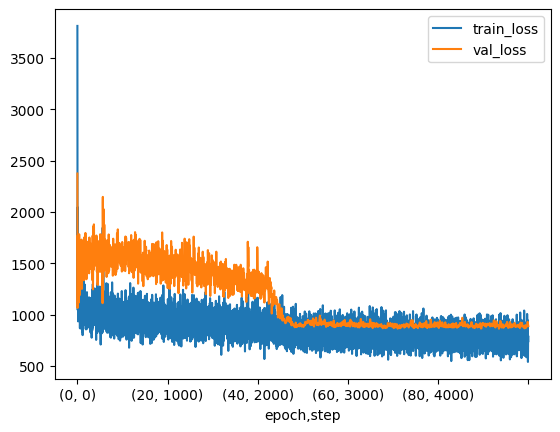

In [6]:
import pandas as pd

df_res = pd.read_csv(Path(trainer.logger.log_dir) / "metrics.csv")
df_res = df_res.set_index(["epoch", "step"])
df_res = pd.concat([df_res["train_loss"].dropna(), df_res["val_loss"].dropna()], axis=1)
df_res.plot()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 604.34it/s]
rmse = 29.41726
r2 = -29.899838944773872


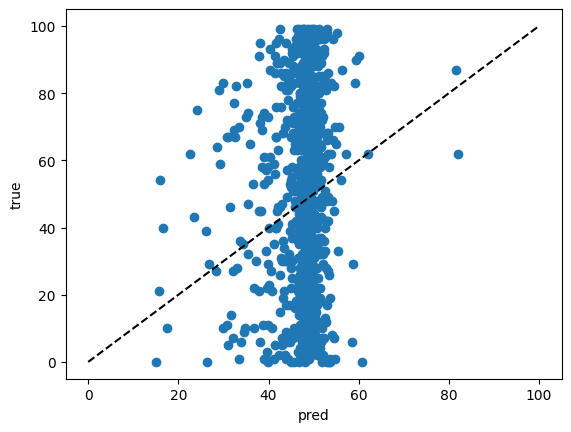

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

fig, ax = plt.subplots()
best_regressor = LitImageRegressor.load_from_checkpoint(
    list(save_dir.glob("*.ckpt"))[0]
)

trainer = L.Trainer()
preds = trainer.predict(best_regressor, test_loader)
preds = torch.cat(preds).squeeze().numpy()

rmse = root_mean_squared_error(preds, test_values)
r2 = r2_score(preds, test_values)

ax.plot(preds, test_values, "o")
ax.plot([0, 100], [0, 100], "k--")
ax.set_ylabel("true")
ax.set_xlabel("pred")
print(f"{rmse = }")
print(f"{r2 = }")